In [11]:
# Load main dataframe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cust = pd.read_pickle('main_df.pkl')

cust.info()

Matplotlib is building the font cache; this may take a moment.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CustomerKey            60398 non-null  int64         
 1   GeographyKey           60398 non-null  int64         
 2   BirthDate              60398 non-null  datetime64[ns]
 3   MaritalStatus          60398 non-null  category      
 4   Gender                 60398 non-null  category      
 5   YearlyIncome           60398 non-null  float64       
 6   TotalChildren          60398 non-null  int64         
 7   NumberChildrenAtHome   60398 non-null  int64         
 8   EnglishEducation       60398 non-null  category      
 9   EnglishOccupation      60398 non-null  object        
 10  HouseOwnerFlag         60398 non-null  category      
 11  NumberCarsOwned        60398 non-null  int64         
 12  DateFirstPurchase      60398 non-null  datetime64[ns]
 13  C

In [30]:
# remove duplicate columns (same name)
cust = cust.loc[:,~cust.columns.duplicated()]



In [10]:
# group by customer - total sales value per customer
# view cust sales value distribution
# view sales value by decile of cust sales value

custValDist = cust.groupby(['CustomerKey'], as_index=False)['SalesAmount'].sum()

custValDist.head()

,CustomerKey,SalesAmount
0,11000,8248.99
1,11001,6383.88
2,11002,8114.04
3,11003,8139.29
4,11004,8196.01


array([[<AxesSubplot:title={'center':'SalesAmount'}>]], dtype=object)

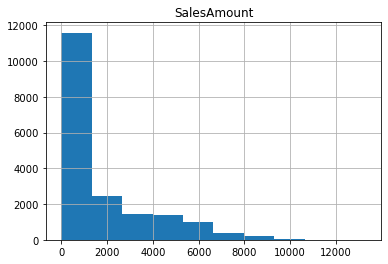

In [15]:
# plot histogram

custValDist.hist(column = 'SalesAmount')

array([[<AxesSubplot:title={'center':'SalesAmount'}>]], dtype=object)

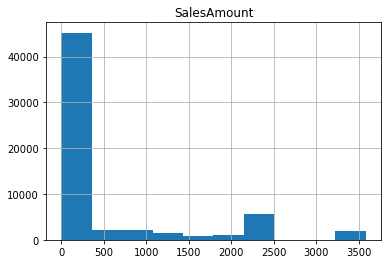

In [17]:
cust.hist(column='SalesAmount')
# distribution of sales value (by item)

In [19]:
# to look at thevalue by decile of customer sales value ie how much are 'high value' customers
# worth in aggregate - calculate deciles, then group by decile and sum

custValDist['Decile'] = pd.qcut(custValDist['SalesAmount'], 10).values.codes

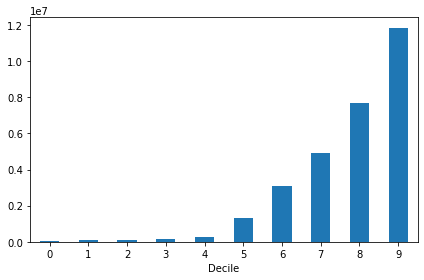

In [24]:
import matplotlib.ticker as mtick
custValDist.groupby('Decile').sum()['SalesAmount'].plot.bar()
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# considerable sale value is concentrated in upper decile customers
# top 2 deciles accounting for $20M.

In [54]:
# we will try a decision tree - regression - to model customers using customer characteristics.

# features

Features = cust.columns[np.r_[0,1,3,4:8,10,11,13,20]]
Label = 'Decile'
# need one row per customer. re-do merge back of custValDist to include total sales value. Then use distinct customer key values

data = pd.merge(custValDist, cust[Features], how='left')

# de-duplicate

data = data.drop_duplicates(subset = ['CustomerKey'])

In [62]:
# preprocess to one hot encode categorical variables
data = pd.get_dummies(data)

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


# features
X = data.drop(columns=['CustomerKey', 'Decile'])
# labels

y = data['Decile']

# split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [68]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 6,
                                  max_depth = 4)
 
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=6)

In [70]:
# predict test values

regressor.score(X_test, y_test)

0.9999743053340581

This is an incredibly high r2 value (effectively 1)
It says that the model can totally predict the decile total sales valueofa customer based on their demographics.

(Personally, I would look for data leakage, although none is immediately apparent. Alternatively, to the pub for drinks!)

Lets look at some details of the model

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


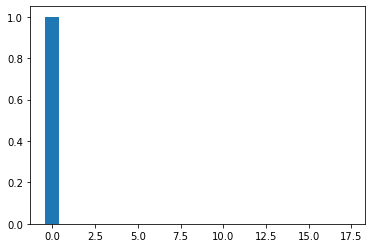

In [72]:
# feature importance

importance = regressor.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [74]:
# feature 0 is doing all the work!

X.info() # sales amount - useful in predicting decile sales value!

# remove

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18484 entries, 0 to 60397
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SalesAmount                 18484 non-null  float64
 1   GeographyKey                18484 non-null  int64  
 2   YearlyIncome                18484 non-null  float64
 3   TotalChildren               18484 non-null  int64  
 4   NumberChildrenAtHome        18484 non-null  int64  
 5   NumberCarsOwned             18484 non-null  int64  
 6   SalesTerritoryKey           18484 non-null  int64  
 7   MaritalStatus_M             18484 non-null  uint8  
 8   MaritalStatus_S             18484 non-null  uint8  
 9   Gender_F                    18484 non-null  uint8  
 10  Gender_M                    18484 non-null  uint8  
 11  HouseOwnerFlag_0            18484 non-null  uint8  
 12  HouseOwnerFlag_1            18484 non-null  uint8  
 13  CommuteDistance_0-1 Miles   184

In [87]:
X = X.drop(columns = 'SalesAmount')

# split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# create a regressor object
model2 = DecisionTreeRegressor(random_state = 6,
                                  max_depth = 9)
 
# fit the regressor with X and Y data
model2.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=9, random_state=6)

In [88]:
# predict test values

model2.score(X_test, y_test)

# significantly poorer outcome this time.
#ordinarily, would cross validate with range of tree depths
# to optimise. By inspection and manually iteration, depth = 9
# found to be best

0.25288146246864773

Feature: 0, Score: 0.21336
Feature: 1, Score: 0.18134
Feature: 2, Score: 0.12362
Feature: 3, Score: 0.10024
Feature: 4, Score: 0.15036
Feature: 5, Score: 0.00504
Feature: 6, Score: 0.02088
Feature: 7, Score: 0.03600
Feature: 8, Score: 0.00602
Feature: 9, Score: 0.00703
Feature: 10, Score: 0.00546
Feature: 11, Score: 0.03294
Feature: 12, Score: 0.02654
Feature: 13, Score: 0.02810
Feature: 14, Score: 0.03244
Feature: 15, Score: 0.01087
Feature: 16, Score: 0.01975


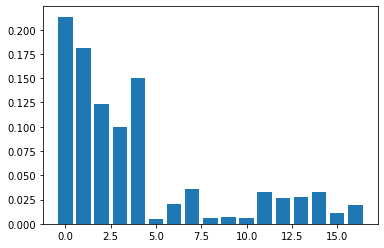

In [89]:
# feature importance
importance = model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


Most important features are Geography Code, Income, No of children, Children at home and No of cars.

Lets use a more powerful algorithm - random forest



In [93]:
y_cl = np.where(y>7,'High','Low')

# train, test sets
X_train, X_test, y_traincl, y_testcl = train_test_split(X, y_cl)


In [100]:
from sklearn.ensemble import RandomForestClassifier

#Create a Classifier
model3=RandomForestClassifier(n_estimators=500,
                             oob_score = True,
                             class_weight = 'balanced_subsample')

# Change labels y from numerical to discrete variable



#Train the model using the training sets y_pred=clf.predict(X_test)
model3.fit(X_train,y_traincl)

y_pred=model3.predict(X_test)

In [101]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_testcl, y_pred))

Accuracy: 0.7831638173555507


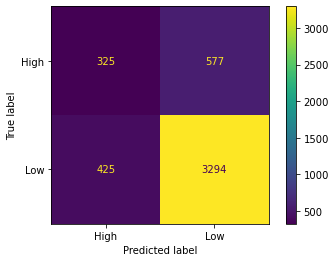

In [102]:
# 78% accurate predictions - quite good,but lets look at a confuion marix to understand better
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_testcl, y_pred, labels=model3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model3.classes_)
disp.plot()
plt.show()

In [ ]:
# as can be seen, model is effective at downselecting lower decile customers 
# at the cost of also downselecting 2/3 of high value customers
# not ideal!

# Further development would incorporate more features, probably including purchase history by category / product type

# in conclusion, an assessment of the value of the model

In [108]:
# mean sales value per customer

totalMean = custValDist['SalesAmount'].mean()


print('Overall mean sales per customer  ${:0,.0f}'.format(totalMean))

# 'true' mean valueoftop 2 decile customers

top2Mean = custValDist.loc[custValDist['Decile']>7,'SalesAmount'].mean()

print('Mean sales per top 2 decile customer  ${:0,.0f}'.format(top2Mean))

Overall mean sales per customer  $1,588
Mean sales per top 2 decile customer  $5,273


In [121]:
modVal=X_test
modVal['Pred']=y_pred
modVal.head()

<ipython-input-121-ebb2e5b14968>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modVal['Pred']=y_pred


,level_0,index,GeographyKey,YearlyIncome,TotalChildren,NumberChildrenAtHome,NumberCarsOwned,SalesTerritoryKey,MaritalStatus_M,MaritalStatus_S,Gender_F,Gender_M,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles,Pred
0,0,23511,609,80000.0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,Low
1,1,48517,612,60000.0,4,0,2,1,1,0,0,1,1,0,0,1,0,0,0,Low
2,2,36963,302,60000.0,0,0,2,4,0,1,1,0,1,0,0,1,0,0,0,Low
3,3,51139,123,30000.0,0,0,1,8,0,1,0,1,1,0,0,0,0,1,0,Low
4,4,47591,31,70000.0,2,0,2,9,0,1,1,0,0,1,0,0,0,0,1,High


In [127]:
# get sales value
highPred = modVal.loc[modVal['Pred']=='High','index']


In [132]:
modMean = custValDist.loc[custValDist['CustomerKey'].isin(highPred),'SalesAmount'].mean()
print('Mean sales of model predicted customer  ${:0,.0f}'.format(modMean))

Mean sales of model predicted customer  $1,737


In summary, the model has produced a very modest improvement over the background average
Further development by expanding the feature set would be recommended. 